In [64]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
%matplotlib inline

In [2]:
#!python -m spacy download en_core_web_sm


In [3]:
#!pip install Spacy

In [4]:
inshort_url = 'https://inshorts.com/en/read/sports'
inshort_url

'https://inshorts.com/en/read/sports'

In [5]:
news_category = inshort_url.split('/')
news_category[-1]      # to get sports category



'sports'

In [6]:
data = requests.get(inshort_url)
data.content

b'<!doctype html><html lang="en"><head><meta charset="utf-8"/><link rel="dns-prefetch" href="https://ajax.googleapis.com"><link rel="dns-prefetch" href="https://assets.inshorts.com"><link rel="dns-prefetch" href="https://static.inshorts.com"><link rel="dns-prefetch" href="https://cdn.ampproject.org"><meta name="theme-color" content="#ffffff"><link rel="shortcut icon" href="/assets/images/favicon.png" type="image/x-icon"/><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/><meta name="viewport" content="width=device-width,initial-scale=1"/><meta http-equiv="X-UA-Compatible" content="IE=edge"/><link rel="icon" sizes="192x192" href="/assets/images/logo_192.png"/><link href="https://inshorts.com" rel="canonical" />\n  <link href="https://inshorts.com" rel="alternate"/>\n  <meta name="description" content="read latest news with inshorts in less than 60 words related to business sports bollywood and technology in india and around the world in both english  hindi"/>\n\n  <meta

In [7]:
# beautiful soup basically parses HTML or XML file and extract the necessary data


def datasetPrepare(url):
    news_data = []
    
    response = requests.get(url)     # retriving the content from the webpage
    
    if response.status_code == 200:   # he status code 200 is part of the "2xx Success" range. 
                                      #   It specifically indicates that the request was successful and the server has fulfilled the client's request.
        
        soup = BeautifulSoup(response.content, 'html.parser')   # Parse the HTML content
        
        
        headlines = soup.find_all('span', attrs={"itemprop": "headline"})          # Extract news articles and headlines
        articles = soup.find_all('div', attrs={"itemprop": "articleBody"})
        
        
        news_category = url.split('/')[-1]                                  # Extract news category from the URL
        
        
        news_data = [{'news_headline': headline.get_text(strip=True),         # Create a list of dictionaries containing news data
                      'news_article': article.get_text(strip=True),
                      'news_category': news_category}
                     for headline, article in zip(headlines, articles)]
    else:
        print("Failed to fetch the webpage:", url)
    
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(news_data)
    
    return df





In [8]:
sports_df=datasetPrepare(inshort_url)
sports_df.head()

,news_headline,news_article,news_category
0,"I was on toes, he's very spicy: ABD on Kohli's...",Discussing Virat Kohli's aggression in RCB's I...,sports
1,"You cannot command or demand respect, need to ...",Former India and CSK skipper MS Dhoni said tha...,sports
2,BCCI seeks MS Dhoni to convince Fleming for he...,BCCI has reportedly approached MS Dhoni to con...,sports
3,Matheesha Pathirana becomes most expensive pla...,Sri Lanka pace sensation Matheesha Pathirana g...,sports
4,New features and updates of COD mobile season 5,The fifth and last season of Call of Duty intr...,sports


In [9]:
print(sports_df.shape)         # 10 rows and 3 columns
print(sports_df.size)

(10, 3)
30


In [10]:
sports_df.describe()

,news_headline,news_article,news_category
count,10,10,10
unique,10,10,1
top,"I was on toes, he's very spicy: ABD on Kohli's...",Discussing Virat Kohli's aggression in RCB's I...,sports
freq,1,1,10


TEXT WRANGLING AND PRE-PROCESSING

In [11]:
nlp = spacy.load('en_core_web_sm')
nlp

In [26]:
nltk.download('stopwords')

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def strip_html_tags(text):                                 # function to parse html tags
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):                            # function to remove unwanted characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):          # function to remove special characters
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):                                     # funcction to lemmatize text (get root words)
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
    # spaCy's lemmatization process treats all pronouns as a single lemma, represented by the string '-PRON-'.
#    this is because the lemma of a pronoun doesn't typically change based on its context; it remains the same as the original pronoun itself.

def remove_stopwords(text, is_lower_case=False):               # function to remove stopwords
    tokenizer = ToktokTokenizer()
    
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Strip each token
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    
    # Join the filtered tokens back into text
    filtered_text = ' '.join(filtered_tokens)    
    
    return filtered_text

In [28]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:                           
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

PRE-PROCESS AND NORMALIZE THE NEWS ARTICLE

In [29]:
sports_df["full_news"]=sports_df.news_headline+":"+sports_df.news_article
sports_df.head()
# By applying these preprocessing steps,
# the normalize_corpus function prepares the text data for further analysis or modeling tasks,
# making it cleaner, more consistent, and easier to process.

,news_headline,news_article,news_category,full_news
0,"I was on toes, he's very spicy: ABD on Kohli's...",Discussing Virat Kohli's aggression in RCB's I...,sports,"I was on toes, he's very spicy: ABD on Kohli's..."
1,"You cannot command or demand respect, need to ...",Former India and CSK skipper MS Dhoni said tha...,sports,"You cannot command or demand respect, need to ..."
2,BCCI seeks MS Dhoni to convince Fleming for he...,BCCI has reportedly approached MS Dhoni to con...,sports,BCCI seeks MS Dhoni to convince Fleming for he...
3,Matheesha Pathirana becomes most expensive pla...,Sri Lanka pace sensation Matheesha Pathirana g...,sports,Matheesha Pathirana becomes most expensive pla...
4,New features and updates of COD mobile season 5,The fifth and last season of Call of Duty intr...,sports,New features and updates of COD mobile season ...


In [30]:
sports_df['clean_text'] = normalize_corpus(sports_df['full_news'])
norm_corpus = list(sports_df['clean_text'])
sports_df.iloc[1][['full_news', 'clean_text']].to_dict()

{'full_news': "You cannot command or demand respect, need to earn it: MS Dhoni:Former India and CSK skipper MS Dhoni said that people in leadership positions should learn that respect cannot be commanded or demanded. At one of CSK's promotional events, Dhoni said that people leading an organisation should learn to earn respect rather than demand it. Just because of their position, one cannot say that people should respect him.",
 'clean_text': 'not command demand respect need earn ms dhoni former india csk skipper ms dhoni say people leadership position learn respect not command demand one csk promotional event dhoni say people lead organisation learn earn respect rather demand position one not say people respect'}

### PERFORM CLUSTERING

In [31]:
sports_df1=sports_df.copy()
sports_df1.head()

,news_headline,news_article,news_category,full_news,clean_text
0,"I was on toes, he's very spicy: ABD on Kohli's...",Discussing Virat Kohli's aggression in RCB's I...,sports,"I was on toes, he's very spicy: ABD on Kohli's...",toe spicy abd kohli aggression vs csk discuss ...
1,"You cannot command or demand respect, need to ...",Former India and CSK skipper MS Dhoni said tha...,sports,"You cannot command or demand respect, need to ...",not command demand respect need earn ms dhoni ...
2,BCCI seeks MS Dhoni to convince Fleming for he...,BCCI has reportedly approached MS Dhoni to con...,sports,BCCI seeks MS Dhoni to convince Fleming for he...,bcci seek ms dhoni convince fleming head coach...
3,Matheesha Pathirana becomes most expensive pla...,Sri Lanka pace sensation Matheesha Pathirana g...,sports,Matheesha Pathirana becomes most expensive pla...,matheesha pathirana become expensive player lp...
4,New features and updates of COD mobile season 5,The fifth and last season of Call of Duty intr...,sports,New features and updates of COD mobile season ...,new feature update cod mobile season fifth las...


In [50]:
sports_df.drop(["news_article","news_category"],axis=1,inplace=True)

In [48]:
sports_df.drop("clean_text",axis=1,inplace=True)

In [51]:
sports_df.head()

,news_headline,full_news
0,"I was on toes, he's very spicy: ABD on Kohli's...","I was on toes, he's very spicy: ABD on Kohli's..."
1,"You cannot command or demand respect, need to ...","You cannot command or demand respect, need to ..."
2,BCCI seeks MS Dhoni to convince Fleming for he...,BCCI seeks MS Dhoni to convince Fleming for he...
3,Matheesha Pathirana becomes most expensive pla...,Matheesha Pathirana becomes most expensive pla...
4,New features and updates of COD mobile season 5,New features and updates of COD mobile season ...


Perform Kmeans clustering

In [52]:
def build_feature_matrix(documents, feature_type='frequency', ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

In [54]:
sports_title = sports_df['news_headline'].tolist()
sports_synopsis = sports_df['full_news'].tolist()

In [55]:
print("Sports title:", sports_title[2])
print("Sports synopsis: ",sports_synopsis[2][:200])

Sports title: BCCI seeks MS Dhoni to convince Fleming for head coach job: Report
Sports synopsis:  BCCI seeks MS Dhoni to convince Fleming for head coach job: Report:BCCI has reportedly approached MS Dhoni to convince Stephen Fleming to take up India's Head Coach’s role. As per Hindustan Times, des


In [61]:
# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(sports_synopsis, feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85, ngram_range=(1, 2))

In [62]:
feature_matrix.shape

(10, 28)

In [63]:
feature_names=vectorizer.get_feature_names_out()
feature_names

array(['2024', 'after', 'against', 'an', 'and', 'csk', 'dhoni', 'event',
       'for', 'for the', 'from', 'has', 'hasn', 'him', 'in', 'in the',
       'india', 'ipl', 'ipl 2024', 'league', 'ms', 'ms dhoni', 'of', 'on',
       'reportedly', 'times', 'up', 'with'], dtype=object)

In [76]:
# to visualize the feature matrix
dtm_Array=feature_matrix.toarray()
dtm_Array[0][2:20]

array([0.21405976, 0.        , 0.14030014, 0.42811952, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.42090042, 0.21405976, 0.        ,
       0.21405976, 0.21405976, 0.        ])

In [69]:
from yellowbrick.cluster import SilhouetteVisualizer

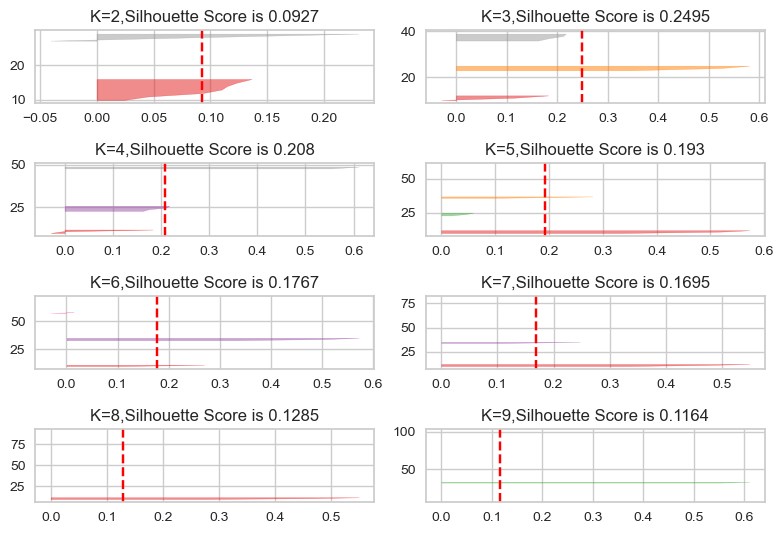

In [72]:
n_clusters=[2,3,4,5,6,7,8,9]

t=1
for j in n_clusters:                    
    plt.subplot(4,2,t)
    model=KMeans(n_clusters=j)
    sil_viz=SilhouetteVisualizer(model)
    sil_viz.fit(feature_matrix)
    plt.title(f'K={j},Silhouette Score is {round(sil_viz.silhouette_score_,4)}')
    t+=1
plt.tight_layout()
plt.show()

In [73]:
# lets try with k=2

<10x28 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>

In [84]:
def k_means(feature_matrix, num_clusters=2):
    km = KMeans(n_clusters=num_clusters, max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [85]:
num_clusters=2
km_obj, clusters = k_means(feature_matrix=feature_matrix, num_clusters=num_clusters)

In [86]:
sports_df["cluster"]=clusters
sports_df.head()

,news_headline,full_news,cluster
0,"I was on toes, he's very spicy: ABD on Kohli's...","I was on toes, he's very spicy: ABD on Kohli's...",0
1,"You cannot command or demand respect, need to ...","You cannot command or demand respect, need to ...",1
2,BCCI seeks MS Dhoni to convince Fleming for he...,BCCI seeks MS Dhoni to convince Fleming for he...,1
3,Matheesha Pathirana becomes most expensive pla...,Matheesha Pathirana becomes most expensive pla...,0
4,New features and updates of COD mobile season 5,New features and updates of COD mobile season ...,0


In [87]:
# get the total number of words per cluster
c = Counter(clusters)
c.items()

dict_items([(0, 7), (1, 3)])

TO CHECK WHICH WORDS BELONG TO WHICH CLUSTER, WE HAVE USED FUNCTIONS INORDER TO FETCH DATA

In [95]:
def get_cluster_data(clustering_obj, sports_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get sports news belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        sports_news = sports_df[sports_df['cluster'] == cluster_num]['news_headline'].values.tolist()
        cluster_details[cluster_num]['sports_news'] = sports_news
    
    return cluster_details


In [96]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print( '-'*20 )
        print( 'Key features:', cluster_details['key_features'])
        print( 'Sports_news in this cluster:')
        print( ', '.join(cluster_details['sports_news']))
        print( '='*40 )


In [97]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 sports_data=sports_df,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)          

In [98]:
print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['in', 'and', 'on', 'for', 'of']
Sports_news in this cluster:
I was on toes, he's very spicy: ABD on Kohli's aggression vs CSK, Matheesha Pathirana becomes most expensive player in LPL history, New features and updates of COD mobile season 5, Ederson to leave Man City in next transfer window: Report, SRH to bat first against KKR in IPL 2024 Qualifier 1, playing XIs announced, England announce provisional squad for UEFA Euro 2024, Mobil 1 and RPPL host car roadshow with F4, IRL cars in Bengaluru
Cluster 1 details:
--------------------
Key features: ['dhoni', 'ms dhoni', 'ms', 'india', 'up']
Sports_news in this cluster:
You cannot command or demand respect, need to earn it: MS Dhoni, BCCI seeks MS Dhoni to convince Fleming for head coach job: Report, BCCI calls Dhoni to convince Fleming for Head Coach role: Reports


# Plot the clusters

In [103]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

In [106]:
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, sports_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using PCA
    pca = PCA(n_components=2, random_state=1)
    # get coordinates of clusters in new low-dimensional space
    #plot_positions = mds.fit_transform(cosine_distance)  
    plot_positions = pca.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': sports_data['cluster'].values.tolist(),
                                       'title': sports_data['news_headline'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.iloc[index]['x'], 
                cluster_plot_frame.iloc[index]['y'], 
                cluster_plot_frame.iloc[index]['title'], size=8)  
    # show the plot           
    plt.show()

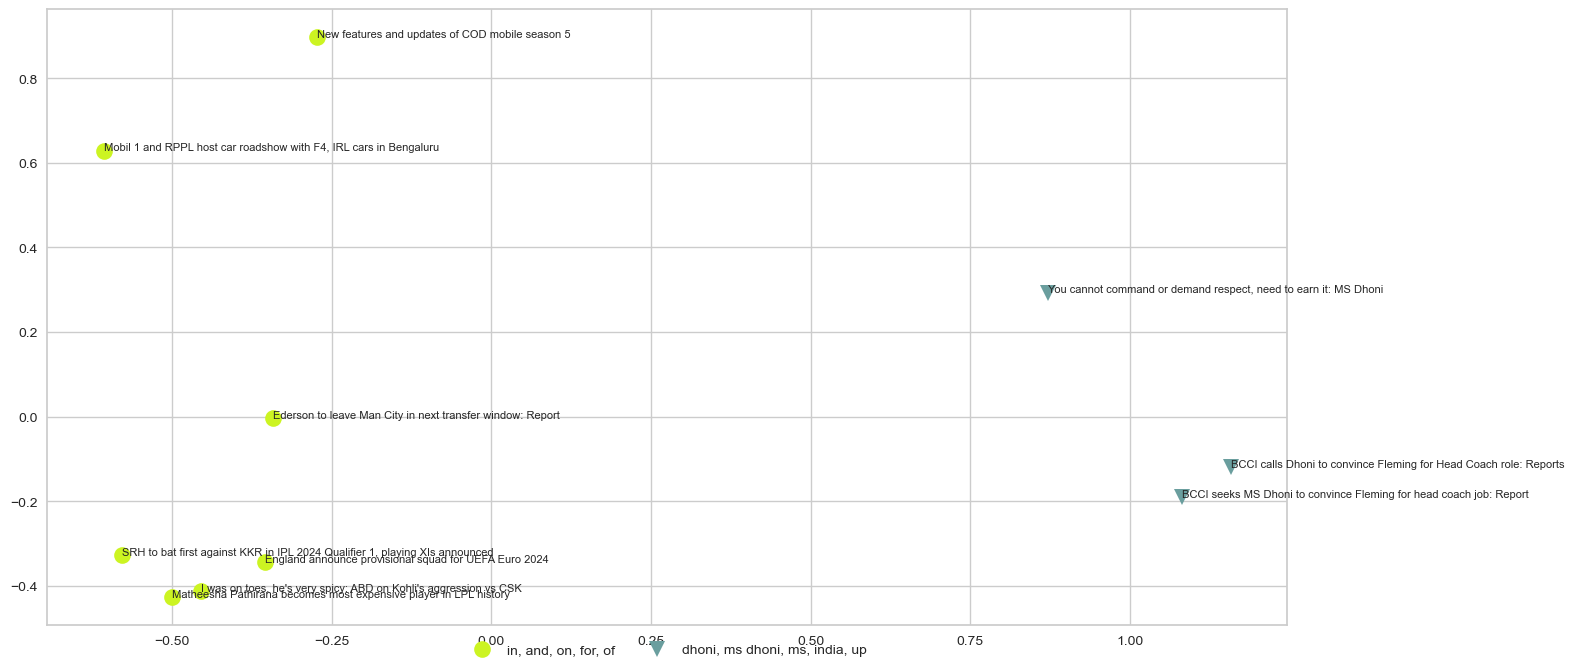

In [107]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              sports_data=sports_df,
              plot_size=(16,8))